Necessary Module Importation

Regression Analysis: Building Models to Predict Store Sales Using Time Series Forecasting

Introduction
Time series forecasting involves making scientific predictions by analyzing historical data with timestamps. This process entails constructing models through a detailed examination of past data, which are then utilized to make informed projections, guiding future strategic decision-making. It's important to recognize that during the forecasting process, the future outcome is entirely unknown and can only be approximated through meticulous analysis and evidence-based assumptions.

Project Objective
The primary goal of this project is to predict product unit sales across various stores, aiming to enhance inventory management, refine marketing strategies, and optimize pricing decisions for Favorita Corporation. To achieve this objective, we employ a combination of time series analysis and regression-based machine learning algorithms within the CRISP-DM framework.

This analysis seeks to identify the most effective prediction model from a diverse set of machine learning algorithms tested. The chosen model will be recommended to Favorita Corporation, providing valuable insights to facilitate informed decisions regarding retail sales, promotional activities, and customer satisfaction. By leveraging time series regression analysis, we aim to achieve a robust and reliable forecast of store sales, thereby supporting strategic planning and operational efficiency.

HYPOTHESIS TESTING 

Null Hypothesis (H0): The predictive model does not significantly improve the accuracy of unit sales forecasts for products at Favorita stores compared to a baseline model (e.g., a naive forecast using historical averages or a simple moving average).

Alternative Hypothesis (H1): The predictive model significantly improves the accuracy of unit sales forecasts for products at Favorita stores compared to a baseline model.

ANALYTICAL QUESTIONS
1.Is the train dataset complete (has all the required dates)?
2.Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3.Compare the sales for each month across the years and determine which month of which year had the highest sales.
4.Did the earthquake impact sales?
5.Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6.Are sales affected by promotions, oil prices and holidays?
7.What analysis can we get from the date and its extractable features?
8.Which product family and stores did the promotions affect.
9.What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10.Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.


In [1]:
#Import libraries needed for data manipulation, cleaning and visualizations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
# Models

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor


In [2]:
#import all the necessary libraries need to laod data from microsoft SQL server

import pyodbc    
from dotenv import dotenv_values
import warnings 

warnings.filterwarnings('ignore')

In [3]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=y"
connection = pyodbc.connect(connection_string)

In [4]:
query="SELECT * FROM dbo.oil"
query2="SELECT * FROM dbo.holidays_events"
query3= "SELECT * FROM dbo.stores"
oil_data= pd.read_sql(query, connection)
holidays_data= pd.read_sql(query2, connection)
stores_data= pd.read_sql(query3, connection)

ONEDRIVE DATASET

In [5]:
sample_submission = pd.read_csv(r'C:\Users\DELL\Downloads\PROJECT@AZUBI\Regression-Analysis-A-Time-Series-Project\Notebook\datasets\sample_submission.csv')
test = pd.read_csv(r'C:\Users\DELL\Downloads\PROJECT@AZUBI\Regression-Analysis-A-Time-Series-Project\Notebook\datasets\test.csv')

LOADING DATA FROM AZUBI GITHUB REPOSITORY

In [6]:
train= pd.read_csv(r'C:\Users\DELL\Downloads\PROJECT@AZUBI\Regression-Analysis-A-Time-Series-Project\Notebook\datasets\train.csv')
transactions= pd.read_csv(r'C:\Users\DELL\Downloads\PROJECT@AZUBI\Regression-Analysis-A-Time-Series-Project\Notebook\datasets\transactions.csv')

DATA PREVIEW AND INVESTIGATIONS

In [7]:
holidays_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [9]:
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [10]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [11]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [12]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


Data Wrangling
Data wrangling, also known as data munging, involves transforming and mapping raw data into a more useful format for analysis. This process typically includes cleaning, structuring, and enriching the raw data to ensure its quality and usability for building predictive models. Effective data wrangling is crucial for accurate and reliable time series forecasting. we can ensure that the dataset is well-prepared for time series forecasting, leading to more accurate and insightful predictions.

In [13]:
holidays_data

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [14]:
holidays_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [15]:
holidays_data.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

OBSERVATIONS
1.Holiday Dataset Structure: The holiday dataset comprises 360 rows and 6 columns, providing a comprehensive overview of holiday-related data points.

2.Date Column Format: The date column is currently in an object (string) format, which will need to be converted to a datetime format for proper time series analysis.

3.Data Completeness: The dataset is complete with no missing values, ensuring the integrity and reliability of the data for subsequent analysis.

In [16]:
oil_data

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997
...,...,...
1213,2017-08-25,47.650002
1214,2017-08-28,46.400002
1215,2017-08-29,46.459999
1216,2017-08-30,45.959999


In [17]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [18]:
oil_data.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

OBSERVATIONS
1.Oil Dataset Structure: The oil dataset consists of 1218 rows and 2 columns, providing extensive information on oil prices over time.

2.Missing Values: The dataset contains 43 null values, which will need to be addressed through data cleaning techniques to ensure the accuracy of the analysis.

3.Data Uniqueness: There are no duplicate entries in the dataset, maintaining its integrity.

4.Date Column Format: The date column is currently in an object (string) format and needs to be converted to a datetime format to facilitate proper time series analysis.

In [19]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [20]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [21]:
transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

OBSERVATIONS
1.Data Completeness: The dataset is fully populated with no null values, ensuring high data quality and reliability for analysis.

2.Date Column Format: The date column is currently stored as an object (string) format. For accurate time series analysis, it is necessary to convert this column to a datetime format.

In [22]:
stores_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [23]:
stores_data.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [24]:
stores_data.duplicated().sum()


0

OBSERVATIONS
1.Correct Data Types: All attributes in the dataset are correctly formatted, ensuring that the data is ready for analysis without the need for additional type conversions.

2.No Duplicate Entries: The dataset contains no duplicate records, which maintains its integrity and ensures the uniqueness of each data point.

In [25]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


Observations
1.Date Column Format: The date column is currently in 'Object' format (string). For precise and efficient time series analysis, it is essential to convert this column to a 'Datetime' format, which will enable accurate date-based operations and insights.

Data Visualization

Univariate Analysis

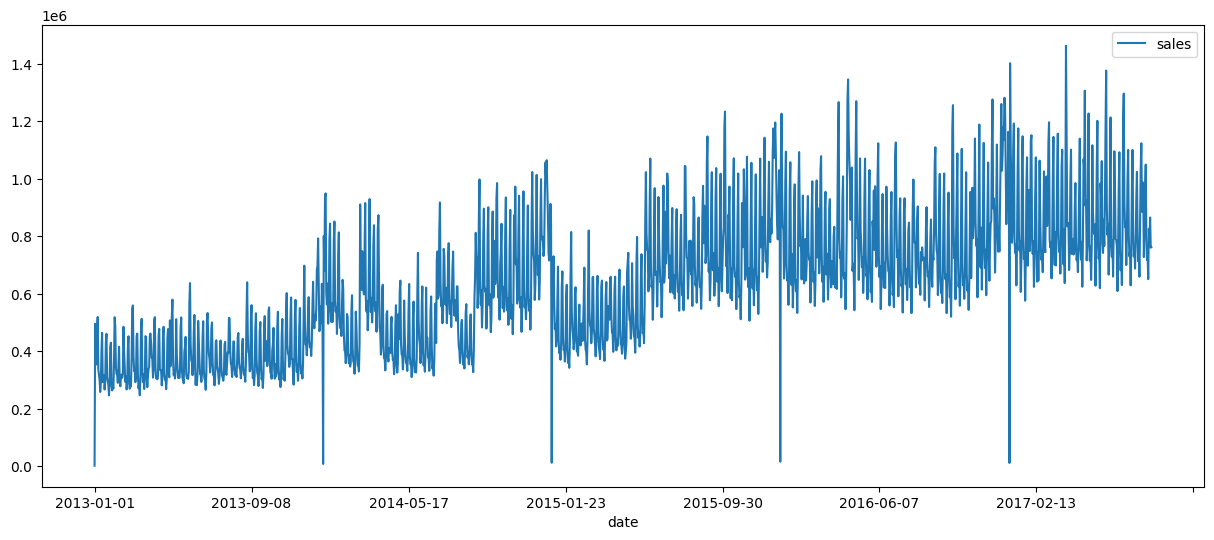

In [26]:
sales_trend = train.groupby('date').sales.sum().reset_index()    
sales_trend = sales_trend.set_index('date')

sales_trend.plot(figsize=(15, 6))
plt.show()

OBSERVATIONS
The training data exhibits an upward trend overall, indicating increasing sales over time. However, it is noteworthy that there is a significant decline in sales at the beginning of each year. This recurring pattern suggests potential seasonal factors or market dynamics that negatively impact sales during this period.








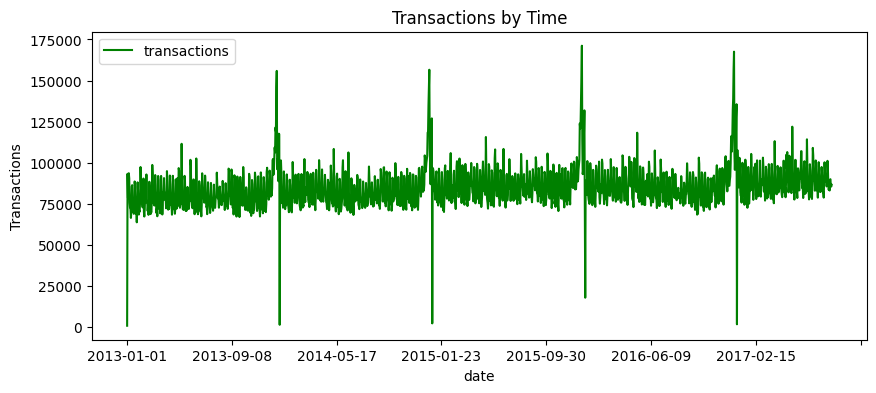

In [27]:
transaction_trends = transactions.groupby('date').transactions.sum().reset_index()
transaction_trends = transaction_trends.set_index('date')

transaction_trends.plot(figsize = (10,4), color= ('green'))
plt.title('Transactions by Time')
plt.ylabel('Transactions')
plt.show()

OBSERVATIONS
A detailed analysis reveals a consistent upward trend in yearly transactions, with 2016 emerging as the year with the highest sales records. Despite this overall growth, the month-to-month transaction levels remain relatively stable throughout the years. Notably, there are sharp increases in transactions during year-end periods, highlighting a distinct seasonal pattern in sales activity.








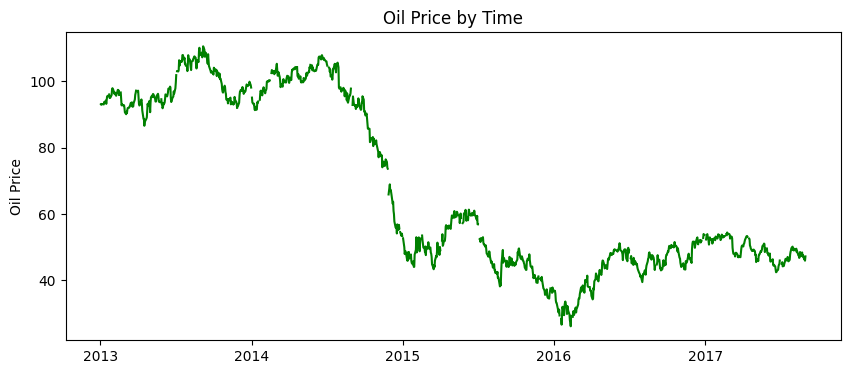

In [28]:
oil_data['date'] = pd.to_datetime(oil_data['date'])
oil_price_overtime = oil_data.groupby('date')['dcoilwtico'].mean().reset_index()
oil_price_by_time = oil_price_overtime.set_index('date')

plt.figure(figsize=(10, 4))
plt.plot(oil_price_by_time.index, oil_price_by_time['dcoilwtico'], color='green')
plt.title('Oil Price by Time')
plt.ylabel('Oil Price')
plt.show()

OBSERVATIONS
The trend reveals a decline in oil prices starting from 2015. This downward trajectory is further interrupted by noticeable disruptions, which are linked to the presence of missing or NaN values in the dataset. These gaps underscore the need for careful data cleaning to ensure an accurate and continuous analysis of the oil price trends.

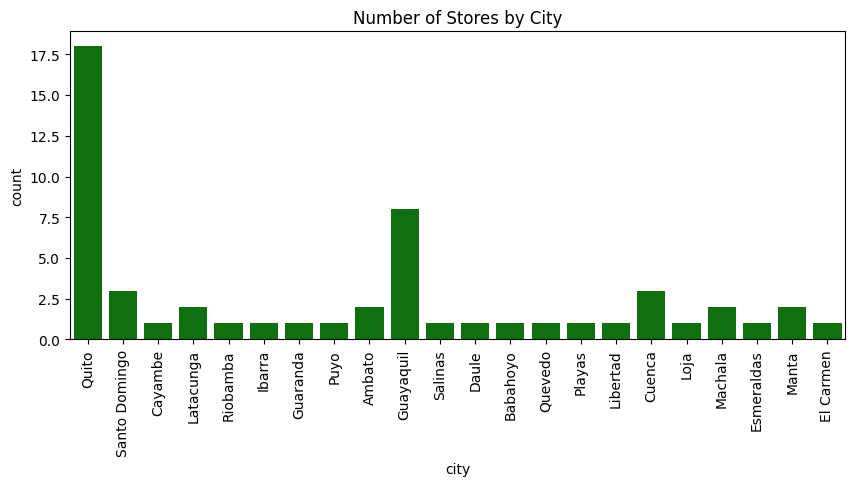

In [29]:
stores_data.set_index('store_nbr', inplace=True)
plt.figure(figsize=(10, 4))
sns.countplot(data=stores_data, x='city', color= 'green')
plt.xticks(rotation=90)
plt.title('Number of Stores by City')
plt.show()

OBSERVATIONS
The visual representation reveals that Quito and Guayaquil have the highest number of stores compared to other cities, which typically maintain an average of one store each. This concentration of stores in Quito and Guayaquil highlights their significance as major retail hubs within the dataset.








Holidays investigation

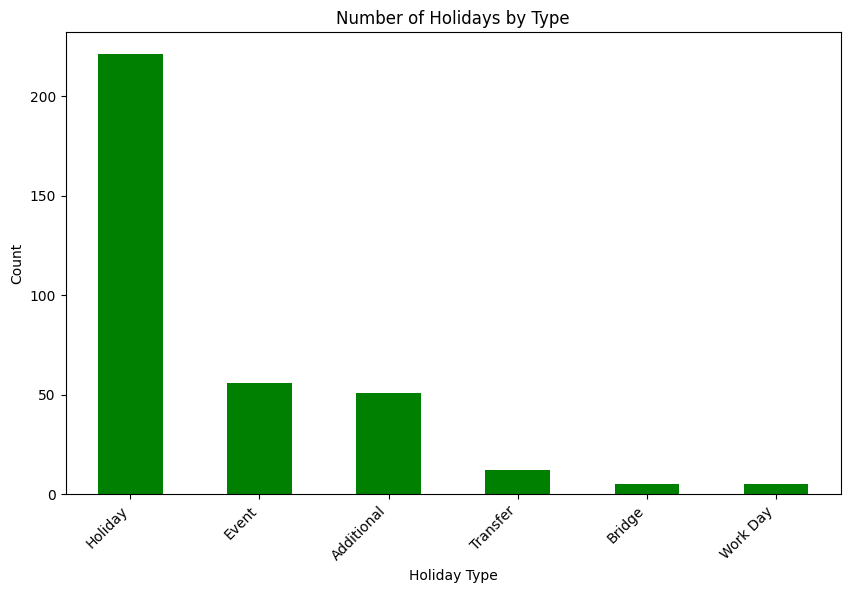

In [30]:
holiday_counts = holidays_data['type'].value_counts()

plt.figure(figsize=(10, 6))
holiday_counts.plot(kind='bar', color='green')
plt.title('Number of Holidays by Type')
plt.xlabel('Holiday Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

Data Preparation
Converting the date columns from their current format to a proper datetime format is essential. This transformation will enable accurate time series analysis and facilitate various date-based operations, such as sorting, filtering, and time-based aggregation, ensuring the integrity and precision of our analysis.

In [31]:
train['date'] = pd.to_datetime(train['date'])
oil_data['date'] = pd.to_datetime(oil_data['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
holidays_data['date'] = pd.to_datetime(holidays_data['date'])
test['date'] = pd.to_datetime(test['date'])

Hypothesis & Questions

1.Is the train dataset complete (has all the required dates)?


In [32]:
expected_dates = pd.date_range(start=train['date'].min(), end=train['date'].max(), freq='D')
missing_dates = expected_dates[~expected_dates.isin(train['date'])]

if missing_dates.empty:
    print("The train dataset is complete.")
else:
    print("The train dataset is missing dates:")
    for date in missing_dates:
        print(date)

The train dataset is missing dates:
2013-12-25 00:00:00
2014-12-25 00:00:00
2015-12-25 00:00:00
2016-12-25 00:00:00


Observations
The absence of data on December 25th in the train dataset for the years 2013, 2014, 2015, and 2016 suggests that no sales transactions were recorded on these dates. This gap is likely due to the organization observing the Christmas holiday, leading to a cessation of business activities and data collection during this period. This pattern is consistent across different weekdays for each year: Wednesday in 2013, Thursday in 2014, Friday in 2015, and Sunday in 2016, reinforcing the conclusion that the missing data corresponds to the holiday observance.








2.Dates with highest and lowest Sales


Dates with the lowest sales for each year:
         year       date  sales
0        2013 2013-01-01    0.0
648648   2014 2014-01-01    0.0
1297296  2015 2015-01-01    0.0
1945944  2016 2016-01-01    0.0
2596374  2017 2017-01-01    0.0

Dates with the highest sales for each year:
         year       date       sales
562596   2013 2013-11-12   46271.000
1257246  2014 2014-12-08   45361.000
1916586  2015 2015-12-14   40351.460
2163723  2016 2016-05-02  124717.000
2760297  2017 2017-04-02   38422.625


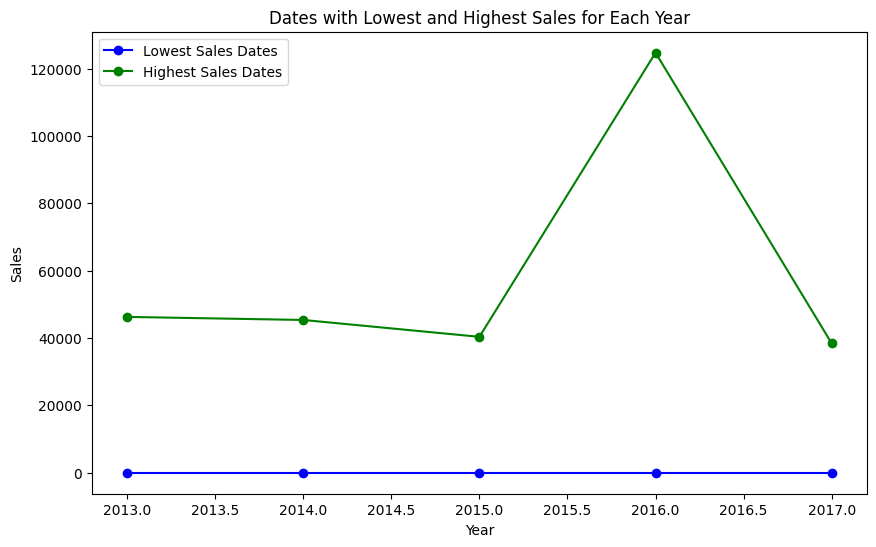

In [33]:
#train['date'] = pd.to_datetime(train_data['date'])
train['year'] = train['date'].dt.year
lowest_sales_dates = train.loc[train.groupby('year')['sales'].idxmin()][['year', 'date', 'sales']]
highest_sales_dates = train.loc[train.groupby('year')['sales'].idxmax()][['year', 'date', 'sales']]
print("Dates with the lowest sales for each year:")
print(lowest_sales_dates)
print("\nDates with the highest sales for each year:")
print(highest_sales_dates)


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lowest_sales_dates['year'], lowest_sales_dates['sales'], color='blue', label='Lowest Sales Dates', marker='o')
ax.plot(highest_sales_dates['year'], highest_sales_dates['sales'], color='green', label='Highest Sales Dates', marker='o')
ax.set_xlabel('Year')
ax.set_ylabel('Sales')
ax.set_title('Dates with Lowest and Highest Sales for Each Year')
ax.legend()
plt.show()

3.Impact of April 16, 2016 earthquake on sales.

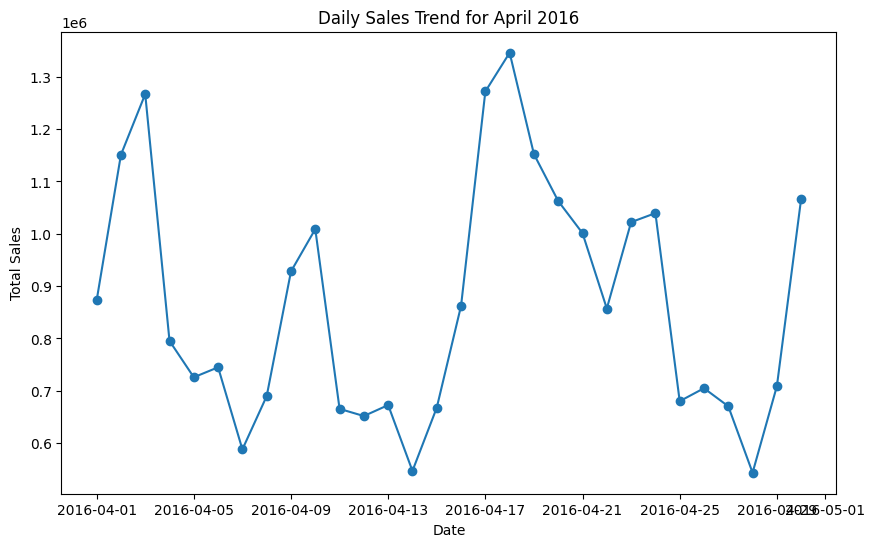

In [34]:
#filter out all the sales that occurred in April 2016
april_2016= train[(train['date']>='2016-04-1')& (train['date']<='2016-04-30')]
#april_2016
#group data by date and the sum of daily sales for April
sales_trend= april_2016.groupby(['date'])['sales'].sum()

plt.figure(figsize=(10, 6))
plt.plot(sales_trend.index, sales_trend.values, marker='o', linestyle='-')
plt.title('Daily Sales Trend for April 2016')
plt.xlabel('Date')
plt.ylabel('Total Sales')

plt.show()

Observations
The earthquake on April 16th, 2016, did not appear to have a noticeable impact on sales. The chart above shows a consistent upward trend in sales from April 16th, 2016, to April 22nd, 2016. Despite the occurrence of the earthquake, sales continued to follow their established pattern, indicating that the event did not disrupt consumer purchasing behavior or retail operations significantly during this period. This resilience suggests that either the earthquake's impact was minimal on the retail sector, or that there were effective measures in place to maintain sales continuity.








4. TOP FIVE STORES WITH THE MOST TRANSACTIONS



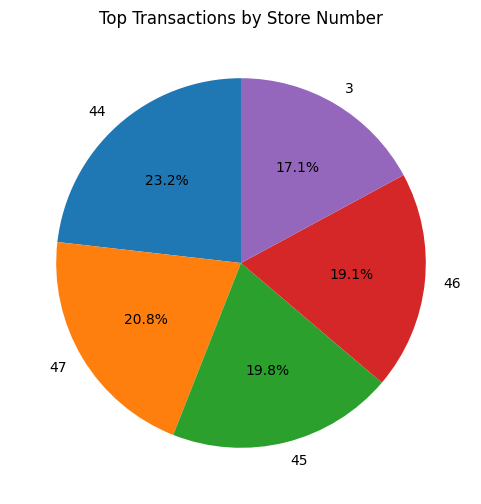

In [35]:
top_transactions= transactions.groupby('store_nbr')['transactions'].sum().sort_values(ascending=False).head()

top_transactions.plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(6, 6))
plt.title('Top Transactions by Store Number')
plt.ylabel('') 
plt.show()

Observations
Store 44 stands out with the highest number of transactions, surpassing other stores by a significant margin of 23.2%. This indicates that Store 44 is a key location for sales activity, potentially due to factors such as its strategic location, larger customer base, or more effective sales and marketing strategies. The notable difference in transaction volume highlights Store 44's critical role in the overall performance of the retail network.

5.WHICH CITY HAS THE HIGHEST STORES?

Text(0.5, 1.0, 'Number of store by cities')

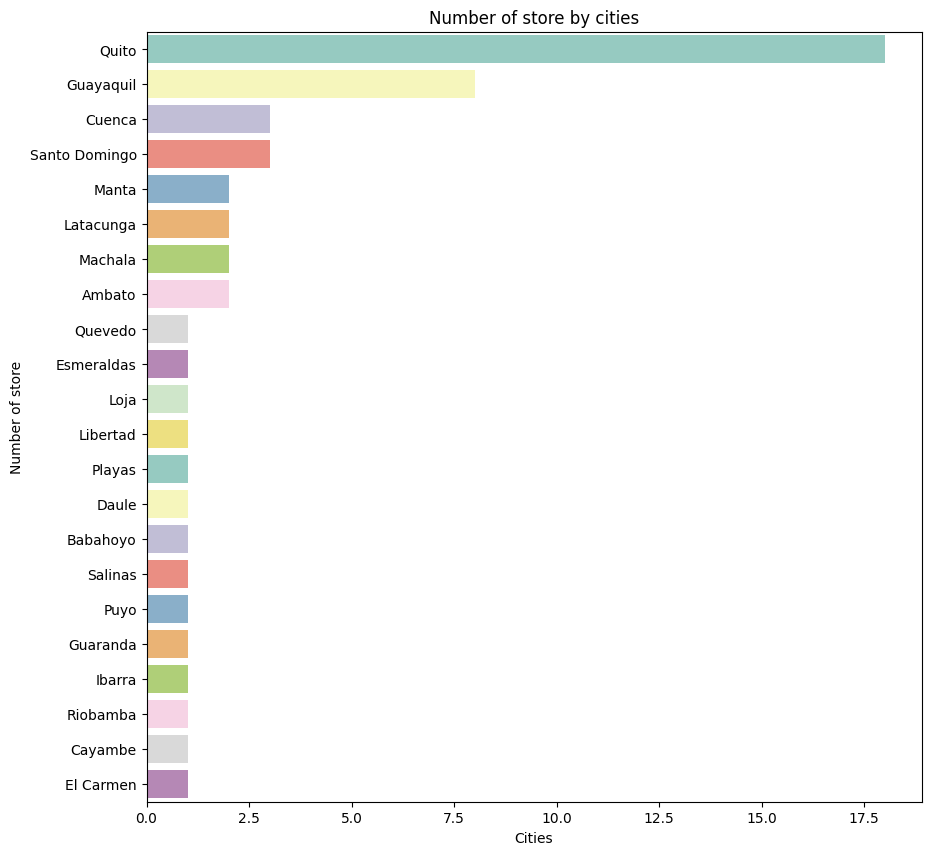

In [36]:
stores_by_cities= stores_data['city'].value_counts()
plt.figure(figsize=(10,10))
colors = sns.color_palette('Set3', n_colors=len(stores_by_cities))
sns.barplot(x=stores_by_cities, y=stores_by_cities.index, palette=colors)
plt.xlabel('Cities')
plt.ylabel('Number of store')
plt.title('Number of store by cities')

Based on our analysis, Quito stands out as the city with the highest concentration of stores, indicating a significant retail presence and possibly a robust consumer market. This suggests Quito's strategic importance for our business operations and highlights the city's potential as a key market for expansion and targeted marketing efforts.

RESET INDEX TO DATE COLUMN

In [37]:
train.set_index('date', inplace= True)

STATIONARITY TEST (KPSS TEST)
In time series analysis, performing a stationarity test is essential to determine whether the data remains consistent over time. For this project, I will utilize the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test to assess the stationarity of the data. This test specifically checks for the presence of a unit root, helping us identify if the time series has a constant mean and variance over time. Establishing stationarity is crucial as it influences the choice of models and the reliability of forecasts derived from the data.

In [38]:
stats,p,lags,critical_values = kpss(train['sales'],'ct')

print(f"Stats: {stats}\n")
print(f"P-Value: {p}\n")
print(f"Lags: {lags}\n")
print(f"Critical Values: {critical_values}\n")

if p< 0.05:
    print('The data is not stationary')
else:
    print('The dataset is stationary')

Stats: 1.1088612328908567

P-Value: 0.01

Lags: 647

Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}

The data is not stationary


DATA DIFFENCING

In [39]:
sales_data = train['sales']

# Apply a logarithmic transformation (natural logarithm)
log_sales_data = np.log1p(sales_data)  # Using np.log1p to handle zero values safely

# Replace the 'sales' column with the transformed data in the DataFrame
train['sales'] = log_sales_data

# Perform first-order differencing
first_order_diff = train['sales'].diff(periods=1).dropna()

# Perform KPSS test on the differenced data
kpss_result = sm.tsa.kpss(first_order_diff)

# Extract KPSS test results for differenced data
kpss_statistic, p_value, lags, critical_values = kpss_result

# Print results
print(f'KPSS Statistic (Differenced Data): {kpss_statistic}')
print(f'p-value (Differenced Data): {p_value}')
print(f'Number of Lags Used (Differenced Data): {lags}')
print(f'Critical Values (Differenced Data): {critical_values}')

# Check if the differenced data is stationary
if p_value > 0.05:
    print('The differenced data is stationary. You can proceed with modeling.')
else:
    print('The differenced data is not stationary.')

KPSS Statistic (Differenced Data): 0.00010866464840598456
p-value (Differenced Data): 0.1
Number of Lags Used (Differenced Data): 411
Critical Values (Differenced Data): {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The differenced data is stationary. You can proceed with modeling.


Feature Engineering and Modelling

In [40]:
#split data into x and y

x= train.drop(['sales','id'], axis=1)

y= train['sales']

LABEL ENCODED

In [41]:
label_encoder = LabelEncoder()

# Iterate through each column in the x dataset
for column in x.columns:
    # Check if the column data type is object (categorical) or bool
    if x[column].dtype == 'object':
        # Fit and transform the label encoder on the combined data
        x[column] = label_encoder.fit_transform(x[column])

In [42]:
X_train, X_eval, Y_train, Y_eval= train_test_split(x,y, test_size= 0.2, random_state= 42, shuffle= False)
 

In [43]:
# Define preprocessing steps for numerical and categorical features
numerical_features = x.select_dtypes(include='number').columns
categorical_features = x.select_dtypes(include='object').columns

In [44]:
# CREATE A PIPELINE FOR NUMERICAL AND CATEGORICAL DATA


numerical_data= Pipeline(steps=[
    ('num_imputer',SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    
])


categorical_data= Pipeline(steps=[
    ('cat_imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(handle_unknown='ignore')),
    
    
])

Preprocessor= ColumnTransformer([
    ('numerical',numerical_data,numerical_features ),
    ('categorical',categorical_data,categorical_features)
])

XGBOOST MODEL

In [45]:
xgboost_model = Pipeline([
    ('preprocessor', Preprocessor),
    ('Xgboost_model', XGBRegressor())
])

xgboost_model.fit(X_train,Y_train)

xgboost_forecast = xgboost_model.predict(X_eval)

In [46]:
Y_eval = np.clip(Y_eval, a_min=0, a_max=None)
xgboost_forecast = np.clip(xgboost_forecast, a_min=0, a_max=None)

 #Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_eval,  xgboost_forecast)


# Calculate Mean Squared Logarithmic Error (MSLE)
msle = mean_squared_log_error(Y_eval,  xgboost_forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
rmsle = msle**0.5

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')

Mean Squared Error (MSE): 0.5160461986314435
Mean Squared Logarithmic Error (MSLE): 0.07475420679535093
Root Mean Squared Error (RMSE): 0.718363556029566
Root Mean Squared Logarithmic Error (RMSLE): 0.27341215553693093


The evaluation metrics for the XGBoost model demonstrate strong performance, indicating that the model is making accurate predictions with minimal errors. This conclusion is supported by the low values of Mean Squared Error (MSE), Mean Squared Logarithmic Error (MSLE), and Mean Absolute Error (MAE), all of which signify that the predictions closely match the actual values on average. Additionally, the moderate values of Root Mean Squared Error (RMSE) and Root Mean Squared Logarithmic Error (RMSLE) imply that the prediction errors, while present, are not excessively large. Overall, these metrics highlight the model's effectiveness in capturing the underlying patterns in the data and producing reliable forecasts.








2.LINEAR REGRESSION MODEL

In [47]:
linear_reg_model = Pipeline([
    ('preprocessor', Preprocessor),
    ('Linear_model', LinearRegression())
])

linear_reg_model.fit(X_train,Y_train)

linear_reg_forecast = linear_reg_model.predict(X_eval)

EVALUATE MODEL

In [48]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_eval, linear_reg_forecast)

# Calculate Mean Squared Logarithmic Error (MSLE)
msle = mean_squared_log_error(Y_eval, linear_reg_forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
rmsle = msle**0.5

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')

Mean Squared Error (MSE): 4.980527857489615
Mean Squared Logarithmic Error (MSLE): 0.5100912984520837
Root Mean Squared Error (RMSE): 2.231709626606834
Root Mean Squared Logarithmic Error (RMSLE): 0.7142067616958577


The Root Mean Squared Logarithmic Error (RMSLE) for the model is 0.71, which suggests that the model's performance is suboptimal. This relatively high error indicates that the model is struggling to accurately predict the logarithmic differences between the actual and predicted values. Consequently, we will explore alternative models to identify a more accurate and reliable option for our predictions.

3.DESCISION TREE MODEL

In [49]:
# Descision tree model
descision_tree = Pipeline([
    ('preprocessor', Preprocessor),
    ('descision_tree', DecisionTreeRegressor(random_state=42))
])

descision_tree.fit(X_train,Y_train)

descision_tree_forecast = descision_tree.predict(X_eval)

EVALUATE MODEL


In [50]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_eval, descision_tree_forecast)

# Calculate Mean Squared Logarithmic Error (MSLE)
msle = mean_squared_log_error(Y_eval, descision_tree_forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
rmsle = msle**0.5

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')

Mean Squared Error (MSE): 0.42856373459351993
Mean Squared Logarithmic Error (MSLE): 0.06371881436221703
Root Mean Squared Error (RMSE): 0.6546477943089092
Root Mean Squared Logarithmic Error (RMSLE): 0.25242585913930654


The Decision Tree Regressor demonstrated superior performance with an RMSLE score of 0.25. This significantly lower error indicates that the Decision Tree Regressor more accurately captures the relationship between the actual and predicted values compared to the previous model. The improved RMSLE score suggests that this model is more effective at minimizing prediction errors and offers a more reliable option for our forecasting needs.

4.RANDOM FOREST MODEL

In [51]:
#from sklearn.ensemble import GradientBoostingRegressor
Random_forest_model = Pipeline([
    ('preprocessor', Preprocessor),
    ('descision_tree', RandomForestRegressor())
])

Random_forest_model.fit(X_train,Y_train)


Random_forest_model_forecast = Random_forest_model.predict(X_eval)


EVALUATE MODEL

In [52]:
#Y_eval = np.clip(Y_eval, a_min=0, a_max=None)
#Gradient_model_forecast = np.clip(Gradient_model_forecast, a_min=0, a_max=None)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_eval, 
Random_forest_model_forecast)

# Calculate Mean Squared Logarithmic Error (MSLE)
msle = mean_squared_log_error(Y_eval, Random_forest_model_forecast)


# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
rmsle = msle**0.5

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')

Mean Squared Error (MSE): 0.4200862448521957
Mean Squared Logarithmic Error (MSLE): 0.06338119113602167
Root Mean Squared Error (RMSE): 0.6481406057733119
Root Mean Squared Logarithmic Error (RMSLE): 0.2517562136989307


The Random Forest Regressor also exhibited strong performance, achieving the same RMSLE score of 0.25 as the Decision Tree Regressor. Based on these results, both the Decision Tree and Random Forest models have proven to be effective, each demonstrating an RMSLE score of 0.25. These models accurately capture the relationship between actual and predicted values, making them reliable choices for our forecasting needs.

Recommendations

Senior Management: Based on our findings, we recommend that senior management implement a Decision Tree Regressor for predicting retail sales. This model effectively captures both seasonal patterns and trends in time series data, providing reliable forecasts. Additionally, to further improve the model's accuracy, it is essential to enhance data quality by addressing outliers and filling in missing values.

Marketing Team: The marketing team can leverage the Decision Tree Regressor to predict the impact of promotions on retail sales. By analyzing the effects of past promotions, the team can refine its promotional strategies to maximize sales outcomes. Furthermore, the model is invaluable for forecasting sales of new products and assessing the potential impact of new product launches on overall sales performance. This predictive capability will enable the marketing department to make data-driven decisions and optimize their approach to boosting sales.






